# Libarary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from optbinning import BinningProcess, Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks, ScorecardMonitoring
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# pd.options.display.float_format = '{:.3f}'.format


(CVXPY) Jul 31 10:45:52 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 31 10:45:52 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


# Location

In [2]:
os.getcwd()

'C:\\Users\\ramda\\Desktop\\env1\\SCORECARD\\scorecard-build'

# Datasource

In [3]:
datasource = pd.read_excel('output/data_clean.xlsx').set_index('id')
datasource.head(2)

limit_bal     sex education marriage  age  pay_1  pay_2  pay_3  pay_4  \
id                                                                          
1       20000  Wanita       SMA   Lajang   39      0      0      2      2   
2      100000    Pria       SMA   Lajang   49      0      0      0      0   

    pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
id                                                                        
1       3      2    12241.0    16020.0    16457.0    20906.0    20289.0   
2       0      0     1440.0        0.0        0.0        0.0        0.0   

    bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
id                                                                          
1     20407.0      4000      1000      4750         0       600         0   
2         0.0         0         0         0         0         0         0   

    gb_flag  
id           
1         1  
2         0

# Split Data

In [4]:
data_x = datasource.drop(['gb_flag'], axis=1)
data_y = datasource[['gb_flag']]

x_train,x_test,y_train,y_test = train_test_split(
    data_x,data_y,test_size = 0.3,random_state=52
)

# Data Proportion

In [5]:
train_count = y_train['gb_flag'].value_counts()
test_count = y_test['gb_flag'].value_counts()

proportion_table = pd.DataFrame({'Train':train_count,
                                'Test':test_count})
proportion_table.loc['Total'] = proportion_table.sum()
proportion_table['% Train'] = (proportion_table['Train']/proportion_table.loc['Total','Train'] *100).round(2).astype(str)+'%'
proportion_table['% Test'] = (proportion_table['Test']/proportion_table.loc['Total','Test']*100).round(2).astype(str)+'%'
proportion_table.index.name = 'Bad Ratio'
proportion_table

Train  Test % Train  % Test
Bad Ratio                             
0          11591  5094   53.5%  54.86%
1          10075  4192   46.5%  45.14%
Total      21666  9286  100.0%  100.0%

# Binning

In [6]:
variable_names = list(x_train.columns)

binning_fit_params = {
    i:{'monotonic_trend':'auto_asc_desc'}
    for i in variable_names
}
# jika memerlukan binning manual bisa dilakukan juga

# binning_fit_params['nama_kolom'] = {
#     'min_n_bins': 2,
#     'max_n_bins': 5,
#     'user_splits': [
#         ['1','2'],
#         ['1','2']
#     ]
# }



In [7]:
# Seleski IV karena IV <0.01 dianggap lemah dan >0.5 dianggap suspicious
selection_criteria = {
    'iv':{
        'min':0.01,
        'max':0.49
    }
}

#Binning Criteria
binning_process = BinningProcess(
    variable_names,
    selection_criteria = selection_criteria,
    min_n_bins=2,
    max_n_bins=5,
    min_bin_size=0.001,
    binning_fit_params=binning_fit_params
)

#check
binning_process.fit_transform(x_train,y_train['gb_flag'].values).head(2)

sex  education       age  bill_amt1  bill_amt2  bill_amt3  \
id                                                                      
28164  0.104168   0.432259  0.108599   0.917955   0.053371   0.949554   
28738  0.104168  -0.178595 -0.021924   0.917955   0.869638  -0.032375   

       bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  pay_amt3  \
id                                                                     
28164   0.915492   0.995249   0.948056  0.182202  0.000308 -0.011812   
28738   0.915492   0.995249   0.948056 -0.600279  0.000308 -0.011812   

       pay_amt4  pay_amt5  pay_amt6  
id                                   
28164 -0.042440 -0.041927 -0.078088  
28738 -0.196977 -0.135835 -0.152504

# Variable Summary

In [8]:
binning_res = binning_process.summary()
binning_res = binning_res.sort_values('iv', ascending=False)
binning_res

name        dtype   status  selected n_bins        iv        js  \
5       pay_1    numerical  OPTIMAL     False      3  0.899403  0.106882   
8       pay_4    numerical  OPTIMAL     False      2  0.881552  0.096878   
9       pay_5    numerical  OPTIMAL     False      2  0.828686  0.088567   
6       pay_2    numerical  OPTIMAL     False      2  0.740586  0.087163   
7       pay_3    numerical  OPTIMAL     False      2  0.738654  0.085837   
10      pay_6    numerical  OPTIMAL     False      2  0.697941  0.076964   
0   limit_bal    numerical  OPTIMAL     False      5   0.69622  0.082214   
16  bill_amt6    numerical  OPTIMAL      True      5  0.404819  0.049107   
15  bill_amt5    numerical  OPTIMAL      True      5  0.397123  0.048073   
14  bill_amt4    numerical  OPTIMAL      True      5  0.379938  0.045994   
13  bill_amt3    numerical  OPTIMAL      True      5  0.355095  0.042927   
12  bill_amt2    numerical  OPTIMAL      True      5  0.323063  0.039061   
11  bill_amt1    numerical  OPTIMAL      True      5  0.263739  0.032101   
17   pay_amt1    numerical  OPTIMAL      True      5  0.139722  0.017002   
18   pay_amt2    numerical  OPTIMAL      True      5   0.12267  0.014575   
2   education  categorical  OPTIMAL      True      3  0.091243  0.011338   
19   pay_amt3    numerical  OPTIMAL      True      5  0.081713  0.009957   
22   pay_amt6    numerical  OPTIMAL      True      5  0.067823  0.008285   
21   pay_amt5    numerical  OPTIMAL      True      5  0.063007  0.007517   
20   pay_amt4    numerical  OPTIMAL      True      5   0.05324  0.006472   
4         age    numerical  OPTIMAL      True      4  0.052237  0.006459   
1         sex  categorical  OPTIMAL      True      2  0.015448   0.00193   
3    marriage  categorical  OPTIMAL     False      2  0.001843   0.00022   

        gini quality_score  
5   0.443527      0.188154  
8   0.350044      0.137811  
9   0.313123      0.153255  
6   0.375015       0.29643  
7   0.358693      0.278641  
10  0.295024      0.245409  
0   0.434382      0.533509  
16    0.3269      0.771025  
15  0.318699      0.770507  
14   0.30857      0.763404  
13  0.287692      0.729925  
12  0.276216      0.726442  
11  0.250114       0.66289  
17  0.173049      0.332939  
18  0.144554      0.339299  
2   0.149593      0.285006  
19  0.127027      0.074432  
22  0.097571      0.114132  
21  0.076089       0.07814  
20  0.092253       0.17207  
4   0.089706      0.102764  
1   0.061143      0.041497  
3   0.004739      0.001774

In [9]:
# build binnig table yang terseleksi
selected_names = binning_res[binning_res['selected'] == True]['name'].values 

bin_list = []
for name in selected_names:
    bins = binning_process.get_binned_variable(name)
    bin_df = bins.binning_table.build(add_totals=True)

    bin_df.reset_index(inplace=True)
    bin_df.rename(columns={'index':'index_bin'}, inplace=True)
    bin_df = bin_df[bin_df['Count']>0]
    bin_df['name'] = name
    bin_list.append(bin_df)

#Result Summary Binning
all_bin_df = pd.concat(bin_list)
all_bin_df = all_bin_df.drop('JS',axis=1)

# Create Var summary
br = binning_res[['name','dtype','n_bins','iv','gini']]
br.rename(columns={'iv':'total_iv'},inplace=True)

var_summary = br.merge(all_bin_df, on='name',how='left')
var_summary.dropna(inplace=True)
var_summary

name        dtype n_bins  total_iv      gini index_bin  \
7   bill_amt6    numerical      5  0.404819    0.3269         0   
8   bill_amt6    numerical      5  0.404819    0.3269         1   
9   bill_amt6    numerical      5  0.404819    0.3269         2   
10  bill_amt6    numerical      5  0.404819    0.3269         3   
11  bill_amt6    numerical      5  0.404819    0.3269         4   
12  bill_amt6    numerical      5  0.404819    0.3269    Totals   
13  bill_amt5    numerical      5  0.397123  0.318699         0   
14  bill_amt5    numerical      5  0.397123  0.318699         1   
15  bill_amt5    numerical      5  0.397123  0.318699         2   
16  bill_amt5    numerical      5  0.397123  0.318699         3   
17  bill_amt5    numerical      5  0.397123  0.318699         4   
18  bill_amt5    numerical      5  0.397123  0.318699    Totals   
19  bill_amt4    numerical      5  0.379938   0.30857         0   
20  bill_amt4    numerical      5  0.379938   0.30857         1   
21  bill_amt4    numerical      5  0.379938   0.30857         2   
22  bill_amt4    numerical      5  0.379938   0.30857         3   
23  bill_amt4    numerical      5  0.379938   0.30857         4   
24  bill_amt4    numerical      5  0.379938   0.30857    Totals   
25  bill_amt3    numerical      5  0.355095  0.287692         0   
26  bill_amt3    numerical      5  0.355095  0.287692         1   
27  bill_amt3    numerical      5  0.355095  0.287692         2   
28  bill_amt3    numerical      5  0.355095  0.287692         3   
29  bill_amt3    numerical      5  0.355095  0.287692         4   
30  bill_amt3    numerical      5  0.355095  0.287692    Totals   
31  bill_amt2    numerical      5  0.323063  0.276216         0   
32  bill_amt2    numerical      5  0.323063  0.276216         1   
33  bill_amt2    numerical      5  0.323063  0.276216         2   
34  bill_amt2    numerical      5  0.323063  0.276216         3   
35  bill_amt2    numerical      5  0.323063  0.276216         4   
36  bill_amt2    numerical      5  0.323063  0.276216    Totals   
37  bill_amt1    numerical      5  0.263739  0.250114         0   
38  bill_amt1    numerical      5  0.263739  0.250114         1   
39  bill_amt1    numerical      5  0.263739  0.250114         2   
40  bill_amt1    numerical      5  0.263739  0.250114         3   
41  bill_amt1    numerical      5  0.263739  0.250114         4   
42  bill_amt1    numerical      5  0.263739  0.250114    Totals   
43   pay_amt1    numerical      5  0.139722  0.173049         0   
44   pay_amt1    numerical      5  0.139722  0.173049         1   
45   pay_amt1    numerical      5  0.139722  0.173049         2   
46   pay_amt1    numerical      5  0.139722  0.173049         3   
47   pay_amt1    numerical      5  0.139722  0.173049         4   
48   pay_amt1    numerical      5  0.139722  0.173049    Totals   
49   pay_amt2    numerical      5   0.12267  0.144554         0   
50   pay_amt2    numerical      5   0.12267  0.144554         1   
51   pay_amt2    numerical      5   0.12267  0.144554         2   
52   pay_amt2    numerical      5   0.12267  0.144554         3   
53   pay_amt2    numerical      5   0.12267  0.144554         4   
54   pay_amt2    numerical      5   0.12267  0.144554    Totals   
55  education  categorical      3  0.091243  0.149593         0   
56  education  categorical      3  0.091243  0.149593         1   
57  education  categorical      3  0.091243  0.149593         2   
58  education  categorical      3  0.091243  0.149593    Totals   
59   pay_amt3    numerical      5  0.081713  0.127027         0   
60   pay_amt3    numerical      5  0.081713  0.127027         1   
61   pay_amt3    numerical      5  0.081713  0.127027         2   
62   pay_amt3    numerical      5  0.081713  0.127027         3   
63   pay_amt3    numerical      5  0.081713  0.127027         4   
64   pay_amt3    numerical      5  0.081713  0.127027    Totals   
65   pay_amt6    numerical      5  0.067823  0.097571   

# WoE Transformation

In [10]:
x_transformed = pd.DataFrame()

for variable in selected_names:
    bins = binning_process.get_binned_variable(variable)
    x_transformed[variable] = bins.transform(x_train[variable], metric='woe')

x_transformed.head(3)

bill_amt6  bill_amt5  bill_amt4  bill_amt3  bill_amt2  bill_amt1  pay_amt1  \
0   0.948056   0.995249   0.915492   0.949554   0.053371   0.917955  0.182202   
1   0.948056   0.995249   0.915492  -0.032375   0.869638   0.917955 -0.600279   
2  -0.426420  -0.388654  -0.368649  -0.341908  -0.311330  -0.272113  0.060276   

   pay_amt2  education  pay_amt3  pay_amt6  pay_amt5  pay_amt4       age  \
0  0.000308   0.432259 -0.011812 -0.078088 -0.041927 -0.042440  0.108599   
1  0.000308  -0.178595 -0.011812 -0.152504 -0.135835 -0.196977 -0.021924   
2  0.000308  -0.178595 -0.011812 -0.078088 -0.041927 -0.042440  0.108599   

        sex  
0  0.104168  
1  0.104168  
2 -0.148495

# Corelation

In [11]:
corr_matrix = x_transformed.corr().abs()
corr_matrix

bill_amt6  bill_amt5  bill_amt4  bill_amt3  bill_amt2  bill_amt1  \
bill_amt6   1.000000   0.865531   0.792543   0.733530   0.702030   0.667264   
bill_amt5   0.865531   1.000000   0.866767   0.789775   0.748420   0.711774   
bill_amt4   0.792543   0.866767   1.000000   0.858145   0.798967   0.747111   
bill_amt3   0.733530   0.789775   0.858145   1.000000   0.857677   0.796059   
bill_amt2   0.702030   0.748420   0.798967   0.857677   1.000000   0.848634   
bill_amt1   0.667264   0.711774   0.747111   0.796059   0.848634   1.000000   
pay_amt1    0.193088   0.208514   0.236081   0.261475   0.360806   0.195551   
pay_amt2    0.190624   0.207950   0.244930   0.332566   0.177501   0.163385   
education   0.085282   0.089246   0.093576   0.106892   0.111582   0.110241   
pay_amt3    0.241588   0.273065   0.364408   0.199492   0.202926   0.173777   
pay_amt6    0.163916   0.176626   0.165570   0.142462   0.130747   0.124723   
pay_amt5    0.262849   0.090954   0.101482   0.102799   0.095015   0.085478   
pay_amt4    0.239854   0.327289   0.154916   0.155234   0.157485   0.153604   
age         0.012212   0.002882   0.010093   0.031407   0.034990   0.027059   
sex         0.036312   0.041389   0.053772   0.061733   0.063205   0.059801   

           pay_amt1  pay_amt2  education  pay_amt3  pay_amt6  pay_amt5  \
bill_amt6  0.193088  0.190624   0.085282  0.241588  0.163916  0.262849   
bill_amt5  0.208514  0.207950   0.089246  0.273065  0.176626  0.090954   
bill_amt4  0.236081  0.244930   0.093576  0.364408  0.165570  0.101482   
bill_amt3  0.261475  0.332566   0.106892  0.199492  0.142462  0.102799   
bill_amt2  0.360806  0.177501   0.111582  0.202926  0.130747  0.095015   
bill_amt1  0.195551  0.163385   0.110241  0.173777  0.124723  0.085478   
pay_amt1   1.000000  0.306950   0.067953  0.345707  0.274433  0.230475   
pay_amt2   0.306950  1.000000   0.080453  0.340655  0.313735  0.279271   
education  0.067953  0.080453   1.000000  0.082517  0.097568  0.067029   
pay_amt3   0.345707  0.340655   0.082517  1.000000  0.348831  0.286710   
pay_amt6   0.274433  0.313735   0.097568  0.348831  1.000000  0.306705   
pay_amt5   0.230475  0.279271   0.067029  0.286710  0.306705  1.000000   
pay_amt4   0.271799  0.314419   0.082499  0.314756  0.326758  0.280893   
age        0.064582  0.082198   0.030687  0.075401  0.096828  0.068220   
sex        0.004312  0.003931   0.010294  0.001863  0.020403  0.009196   

           pay_amt4       age       sex  
bill_amt6  0.239854  0.012212  0.036312  
bill_amt5  0.327289  0.002882  0.041389  
bill_amt4  0.154916  0.010093  0.053772  
bill_amt3  0.155234  0.031407  0.061733  
bill_amt2  0.157485  0.034990  0.063205  
bill_amt1  0.153604  0.027059  0.059801  
pay_amt1   0.271799  0.064582  0.004312  
pay_amt2   0.314419  0.082198  0.003931  
education  0.082499  0.030687  0.010294  
pay_amt3   0.314756  0.075401  0.001863  
pay_amt6   0.326758  0.096828  0.020403  
pay_amt5   0.280893  0.068220  0.009196  
pay_amt4   1.000000  0.072762  0.000224  
age        0.072762  1.000000  0.091089  
sex        0.000224  0.091089  1.000000

In [12]:
IV = var_summary[['name','total_iv']].drop_duplicates('name')
IV = IV.rename(columns={'total_iv':'iv'})
IV

name        iv
7   bill_amt6  0.404819
13  bill_amt5  0.397123
19  bill_amt4  0.379938
25  bill_amt3  0.355095
31  bill_amt2  0.323063
37  bill_amt1  0.263739
43   pay_amt1  0.139722
49   pay_amt2   0.12267
55  education  0.091243
59   pay_amt3  0.081713
65   pay_amt6  0.067823
71   pay_amt5  0.063007
77   pay_amt4   0.05324
83        age  0.052237
88        sex  0.015448

# 2nd Selection (by Corelation)

In [13]:
cols_to_drop = set()

def compare_iv_and_drop(col1, col2):
    """
    Compare IV 
    """
    iv1 = IV.loc[IV['name'] == col1, 'iv'].values[0]
    iv2 = IV.loc[IV['name'] == col2, 'iv'].values[0]
    if iv1 < iv2:
        cols_to_drop.add(col1)
    else:
        cols_to_drop.add(col2)

for i in range(len(corr_matrix.columns)):
    """
    Compare corelation
    """
    col1 = corr_matrix.columns[i]
    if col1 in cols_to_drop:
        continue
    for j in range(i + 1, len(corr_matrix.columns)):
        col2 = corr_matrix.columns[j]
        if col2 in cols_to_drop:
            continue
        if corr_matrix.loc[col1, col2] > 0.4:
            compare_iv_and_drop(col1, col2)
            if col1 in cols_to_drop:
                break

# Filter out correlated columns from IV
IV_filtered = IV[~IV['name'].isin(cols_to_drop)]

print("Kolom yang dihapus karena korelasi tinggi dan IV lebih besar:")
print(cols_to_drop)
print("\nDataframe IV setelah filtering:")
print(IV_filtered)

Kolom yang dihapus karena korelasi tinggi dan IV lebih besar:
{'bill_amt3', 'bill_amt4', 'bill_amt1', 'bill_amt2', 'bill_amt5'}

Dataframe IV setelah filtering:
         name        iv
7   bill_amt6  0.404819
43   pay_amt1  0.139722
49   pay_amt2   0.12267
55  education  0.091243
59   pay_amt3  0.081713
65   pay_amt6  0.067823
71   pay_amt5  0.063007
77   pay_amt4   0.05324
83        age  0.052237
88        sex  0.015448


In [14]:
final_param = IV_filtered['name'].values

x_transformed = x_transformed[final_param]
final_corelation = x_transformed.corr().abs()
final_corelation

bill_amt6  pay_amt1  pay_amt2  education  pay_amt3  pay_amt6  \
bill_amt6   1.000000  0.193088  0.190624   0.085282  0.241588  0.163916   
pay_amt1    0.193088  1.000000  0.306950   0.067953  0.345707  0.274433   
pay_amt2    0.190624  0.306950  1.000000   0.080453  0.340655  0.313735   
education   0.085282  0.067953  0.080453   1.000000  0.082517  0.097568   
pay_amt3    0.241588  0.345707  0.340655   0.082517  1.000000  0.348831   
pay_amt6    0.163916  0.274433  0.313735   0.097568  0.348831  1.000000   
pay_amt5    0.262849  0.230475  0.279271   0.067029  0.286710  0.306705   
pay_amt4    0.239854  0.271799  0.314419   0.082499  0.314756  0.326758   
age         0.012212  0.064582  0.082198   0.030687  0.075401  0.096828   
sex         0.036312  0.004312  0.003931   0.010294  0.001863  0.020403   

           pay_amt5  pay_amt4       age       sex  
bill_amt6  0.262849  0.239854  0.012212  0.036312  
pay_amt1   0.230475  0.271799  0.064582  0.004312  
pay_amt2   0.279271  0.314419  0.082198  0.003931  
education  0.067029  0.082499  0.030687  0.010294  
pay_amt3   0.286710  0.314756  0.075401  0.001863  
pay_amt6   0.306705  0.326758  0.096828  0.020403  
pay_amt5   1.000000  0.280893  0.068220  0.009196  
pay_amt4   0.280893  1.000000  0.072762  0.000224  
age        0.068220  0.072762  1.000000  0.091089  
sex        0.009196  0.000224  0.091089  1.000000

In [15]:
def style_negative(v):
    return 'color:white; font-weight:bold; background-color:red;' if v > 0.4 else ''


corr_doc_final = final_corelation.style.applymap(style_negative)
corr_doc = corr_matrix.style.applymap(style_negative)
corr_doc.to_excel('output/corelation_matrix.xlsx')
corr_doc_final.to_excel('output/corelation_matrix_final.xlsx')


# 3rd Selection (VIF Check)

In [16]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x_transformed.values,i) for i in range(x_transformed.shape[1])]
vif['Predictor Param'] = x_transformed.columns
vif = vif.sort_values('VIF Factor',ascending = False)
vif =  vif.reset_index(drop=True)
vif = vif[['Predictor Param','VIF Factor']]
vif

Predictor Param  VIF Factor
0        pay_amt3    1.353832
1        pay_amt6    1.303796
2        pay_amt2    1.290118
3        pay_amt4    1.282903
4        pay_amt5    1.243612
5        pay_amt1    1.241445
6       bill_amt6    1.162807
7       education    1.035213
8             age    1.024883
9             sex    1.011493

# Build Scorecard

In [17]:
estimator = LogisticRegression(solver='lbfgs')
scorecard = Scorecard(
    binning_process = binning_process,
    intercept_based=False, # True jika ingin intercept tidak 0
    estimator=estimator,
    scaling_method='min_max',
    scaling_method_params={'min':0,'max':1000} # skala score result
)
scorecard

Scorecard(binning_process=BinningProcess(binning_fit_params={'age': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt1': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt2': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt3': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt4': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt5': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_a...
                                         variable_names=['limit_bal', 'sex',
                                                         'education',
                                                         'marriage', 'age',
                                                         'pay_1', 'pay_2',
                                                         'pay_3', 'pay_4',
                                                         'pay_5', 'pay_6',
                                                         'bill_amt1',
                                                         'bill_amt2',
                                                         'bill_amt3',
                                                         'bill_amt4',
                                                         'bill_amt5',
                                                         'bill_amt6',
                                                         'pay_amt1', 'pay_amt2',
                                                         'pay_amt3', 'pay_amt4',
                                                         'pay_amt5',
                                                         'pay_amt6']),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0})

In [18]:
target = 'gb_flag'
y_list_train = y_train[target].values
y_list_test = y_test[target].values

scorecard.fit(
    x_train,
    y_list_train,
    metric_special='empirical',
    metric_missing='empirical',
    show_digits=2
)


Scorecard(binning_process=BinningProcess(binning_fit_params={'age': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt1': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt2': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt3': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt4': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_amt5': {'monotonic_trend': 'auto_asc_desc'},
                                                             'bill_a...
                                         variable_names=['limit_bal', 'sex',
                                                         'education',
                                                         'marriage', 'age',
                                                         'pay_1', 'pay_2',
                                                         'pay_3', 'pay_4',
                                                         'pay_5', 'pay_6',
                                                         'bill_amt1',
                                                         'bill_amt2',
                                                         'bill_amt3',
                                                         'bill_amt4',
                                                         'bill_amt5',
                                                         'bill_amt6',
                                                         'pay_amt1', 'pay_amt2',
                                                         'pay_amt3', 'pay_amt4',
                                                         'pay_amt5',
                                                         'pay_amt6']),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0})

# Range Score Validation

In [19]:
sc = scorecard.table(style='summary')
sc.groupby('Variable').agg({'Points':[np.min,np.max]}).sum()

Points  min    1.598721e-14
        max    1.000000e+03
dtype: float64

# Model Validation

## Train

In [20]:
y_pred_train = scorecard.predict_proba(x_train)[:,1]

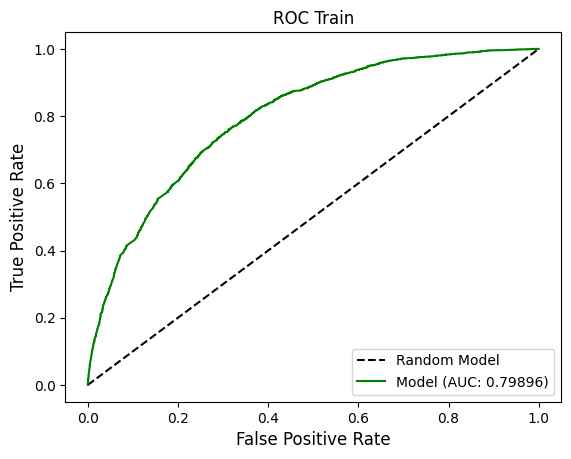

In [21]:
plot_auc_roc(y_list_train,y_pred_train)
plt.title('ROC Train')
plt.savefig('output/ROC_TRAIN.png')

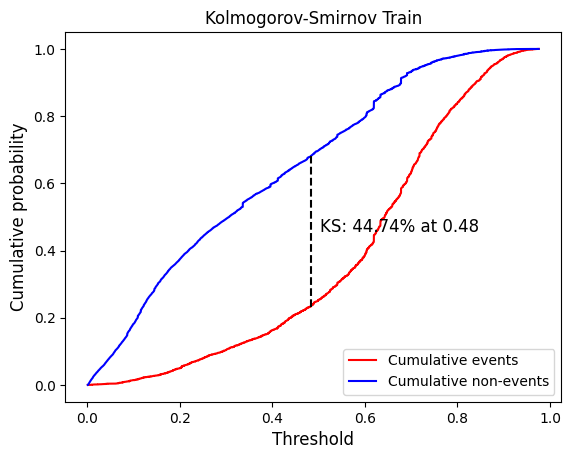

In [22]:
plot_ks(y_list_train,y_pred_train)
plt.title('Kolmogorov-Smirnov Train')
plt.savefig('output/KS_TRAIN.png')

## Test

In [23]:
y_pred_test = scorecard.predict_proba(x_test)[:,1]

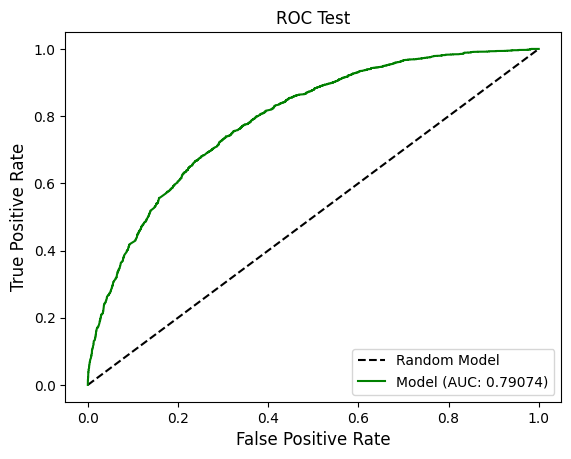

In [24]:
plot_auc_roc(y_list_test,y_pred_test)
plt.title('ROC Test')
plt.savefig('output/ROC_TEST.png')

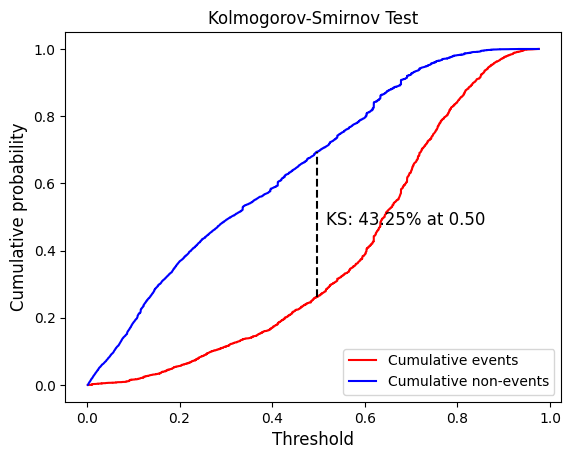

In [25]:
plot_ks(y_list_test,y_pred_test)
plt.title('Kolmogorov-Smirnov Test')
plt.savefig('output/KS_TEST.png')

## PSI

In [26]:
monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart", # uniform, cart,quantile
                                 psi_n_bins=10, verbose=True)

In [27]:
monitoring.fit(x_test, y_list_test, x_train, y_list_train)

2024-07-31 22:46:05,324 | INFO : Monitoring started.
2024-07-31 22:46:05,325 | INFO : Options: check parameters.
2024-07-31 22:46:05,326 | INFO : System stability analysis started.
2024-07-31 22:46:05,463 | INFO : System stability analysis terminated. Time: 0.1374s
2024-07-31 22:46:05,464 | INFO : Variable analysis started.
2024-07-31 22:46:05,507 | INFO : Variable analysis terminated. Time: 0.0425s
2024-07-31 22:46:05,508 | INFO : Monitoring terminated. Time: 0.1847s


ScorecardMonitoring(psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(binning_fit_params={'age': {'monotonic_trend': 'auto_asc_desc'},
                                                                                           'bill_amt1': {'monotonic_trend': 'auto_asc_desc'},
                                                                                           'bill_amt2': {'monotonic_trend': 'auto_asc_desc'},
                                                                                           'bill_amt3': {'monotonic_trend': 'auto_asc_desc'},
                                                                                           'bill_amt4': {'monotonic_trend': 'auto_asc_desc'},
                                                                                           'bill_amt5'...
                                                                       variable_names=['limit_bal',
                                                                                       'sex',
                                                                                       'education',
                                                                                       'marriage',
                                                                                       'age',
                                                                                       'pay_1',
                                                                                       'pay_2',
                                                                                       'pay_3',
                                                                                       'pay_4',
                                                                                       'pay_5',
                                                                                       'pay_6',
                                                                                       'bill_amt1',
                                                                                       'bill_amt2',
                                                                                       'bill_amt3',
                                                                                       'bill_amt4',
                                                                                       'bill_amt5',
                                                                                       'bill_amt6',
                                                                                       'pay_amt1',
                                                                                       'pay_amt2',
                                                                                       'pay_amt3',
                                                                                       'pay_amt4',
                                                                                       'pay_amt5',
                                                                                       'pay_amt6']),
                                        estimator=LogisticRegression(),
                                        scaling_method='min_max',
                                        scaling_method_params={'max': 1000,
                                                               'min': 0}),
                    verbose=True)

In [28]:
psi_table_train_test = monitoring.psi_table()
psi_table_train_test

Bin  Count A  Count E  Count A (%)  Count E (%)       PSI
0         (-inf, 265.87)      547     1392     0.058906     0.064248  0.000464
1       [265.87, 312.26)     1488     3345     0.160241     0.154389  0.000218
2       [312.26, 332.19)     1108     2650     0.119319     0.122311  0.000074
3       [332.19, 337.12)      442     1098     0.047599     0.050678  0.000193
4       [337.12, 351.10)      552     1378     0.059444     0.063602  0.000281
5       [351.10, 385.13)     1303     2939     0.140319     0.135650  0.000158
6       [385.13, 403.95)      544     1240     0.058583     0.057233  0.000031
7       [403.95, 459.51)     1440     3273     0.155072     0.151066  0.000105
8       [459.51, 533.10)     1277     3099     0.137519     0.143035  0.000217
9          [533.10, inf)      585     1252     0.062998     0.057786  0.000450
Totals                       9286    21666     1.000000     1.000000  0.002191

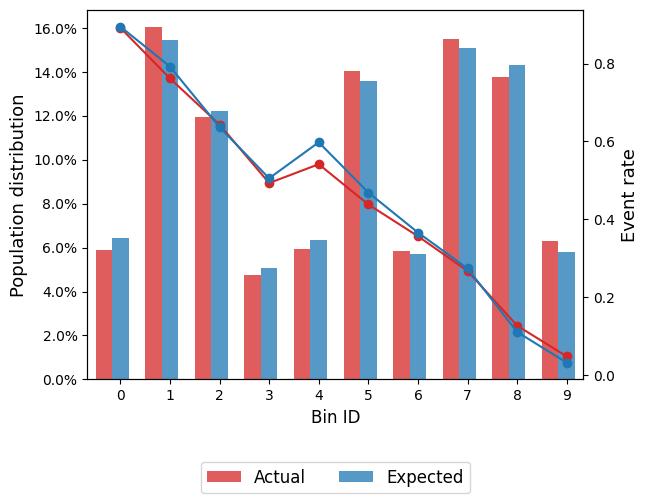

In [29]:
monitoring.psi_plot()

# Score Table

In [30]:
scoring = scorecard.table(style="detailed")

scoring

Variable  Bin id                     Bin  Count  Count (%)  Non-event  \
0        sex       0                [Wanita]  12775   0.589634       7164   
1        sex       1                  [Pria]   8891   0.410366       4427   
2        sex       2                 Special      0   0.000000          0   
3        sex       3                 Missing      0   0.000000          0   
0  education       0  [Lainya, Pascasarjana]   7217   0.333103       4614   
1  education       1               [Sarjana]  10620   0.490169       5208   
2  education       2                   [SMA]   3829   0.176729       1769   
3  education       3                 Special      0   0.000000          0   
4  education       4                 Missing      0   0.000000          0   
0        age       0           (-inf, 23.50)   1327   0.061248        504   
1        age       1          [23.50, 25.50)   1935   0.089310        812   
2        age       2          [25.50, 27.50)   2032   0.093788       1076   
3        age       3            [27.50, inf)  16372   0.755654       9199   
4        age       4                 Special      0   0.000000          0   
5        age       5                 Missing      0   0.000000          0   
0  bill_amt1       0         (-inf, 6154.50)   5282   0.243792       3921   
1  bill_amt1       1     [6154.50, 14120.50)   2569   0.118573       1406   
2  bill_amt1       2   [14120.50, 110526.50)  10945   0.505169       5112   
3  bill_amt1       3  [110526.50, 171460.50)   1441   0.066510        608   
4  bill_amt1       4        [171460.50, inf)   1429   0.065956        544   
5  bill_amt1       5                 Special      0   0.000000          0   
6  bill_amt1       6                 Missing      0   0.000000          0   
0  bill_amt2       0          (-inf, 324.00)   1855   0.085618       1469   
1  bill_amt2       1       [324.00, 6955.50)   3805   0.175621       2789   
2  bill_amt2       2     [6955.50, 13915.50)   2125   0.098080       1165   
3  bill_amt2       3   [13915.50, 134697.50)  11819   0.545509       5405   
4  bill_amt2       4        [134697.50, inf)   2062   0.095172        763   
5  bill_amt2       5                 Special      0   0.000000          0   
6  bill_amt2       6                 Missing      0   0.000000          0   
0  bill_amt3       0            (-inf, 2.50)   1728   0.079756       1352   
1  bill_amt3       1         [2.50, 7721.00)   4192   0.193483       3137   
2  bill_amt3       2     [7721.00, 15368.50)   2340   0.108003       1233   
3  bill_amt3       3   [15368.50, 155779.00)  11947   0.551417       5373   
4  bill_amt3       4        [155779.00, inf)   1459   0.067341        496   
5  bill_amt3       5                 Special      0   0.000000          0   
6  bill_amt3       6                 Missing      0   0.000000          0   
0  bill_amt4       0           (-inf, 69.50)   1941   0.089587       1506   
1  bill_amt4       1        [69.50, 8335.50)   4331   0.199898       3213   
2  bill_amt4       2     [8335.50, 15507.00)   2321   0.107126       1286   
3  bill_amt4       3   [15507.00, 136130.00)  11394   0.525893       5049   
4  bill_amt4       4        [136130.00, inf)   1679   0.077495        537   
5  bill_amt4       5                 Special      0   0.000000          0   
6  bill_amt4       6                 Missing      0   0.000000          0   
0  bill_amt5       0         (-inf, 5163.00)   5667   0.261562       4289   
1  bill_amt5       1      [5163.00, 8822.00)   1157   0.053402        794   
2  bill_amt5       2     [8822.00, 16118.00)   2362   0.109019       1260   
3  bill_amt5       3   [16118.00, 131141.00)  10849   0.500738       4754   
4  bill_amt5       4        [131141.00, inf)   1631   0.075279        494   
5  bill_amt5       5                 Special      0   0.000000          0   
6  bill_amt5       6                 Missing      0   0.000000          0   
0  bill_amt6       0         (-inf, 5449.50)   6275   0.289624       4694   


# Score Distribution

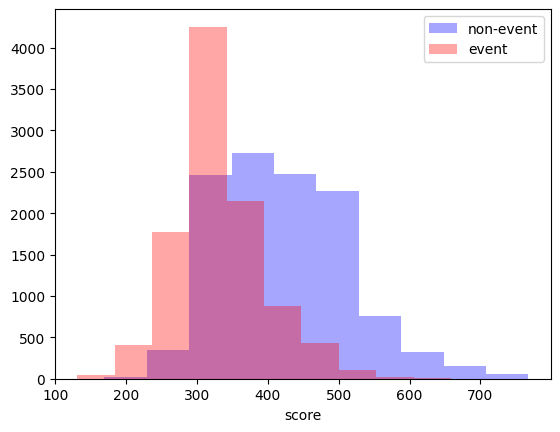

<Figure size 640x480 with 0 Axes>

In [31]:
score = scorecard.score(x_train)
mask = y_list_train == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()
plt.savefig('OUTPUT/DIST_SCORE.png')

In [32]:
intercept_value = scorecard.intercept_
print("Intercept Value:", intercept_value)

Intercept Value: 0


# dump model

In [35]:
joblib.dump(scorecard, 'output/scorecard.joblib')
joblib.dump(binning_process, 'output/binning_process.joblib')


['output/binning_process.joblib']

# Model Documentation

In [34]:
with pd.ExcelWriter("OUTPUT/model_documentation.xlsx", engine='xlsxwriter') as writer:
    proportion_table.to_excel(writer, sheet_name="proportion_table", index=True)
    var_summary.to_excel(writer, sheet_name="var_summary", index=False)
    corr_doc.to_excel(writer, sheet_name="correlation all", index=True)
    corr_doc_final.to_excel(writer, sheet_name="correlation final", index=True)
    scoring.to_excel(writer, sheet_name="score_table", index=False)
    vif.to_excel(writer, sheet_name="vif", index=False)
    psi_table_train_test.to_excel(writer, sheet_name="PSI (Train - Test)", index=False)
    worksheet = writer.book.add_worksheet('PLOT')
    worksheet = writer.sheets['PLOT']
    worksheet.insert_image('A7', 'output/ROC_TRAIN.png')
    worksheet.insert_image('K7', 'output/ROC_TEST.png')
    worksheet.insert_image('A35', 'output/KS_TRAIN.png')
    worksheet.insert_image('K35', 'output/KS_TEST.png')


